## Multivariate Polynomial with Known ROA

state = x = [x1, x2]
dynamics = [-x1 + x2, 0.1x1 - 2x2 - $x1^2$ - 0.1 $x1^3$]

In [7]:
# imports
import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import Markdown, display
from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression)

from pydrake.all import (LinearQuadraticRegulator, MathematicalProgram, Variables,
                         Solve, RealContinuousLyapunovEquation)
from pydrake.examples.pendulum import PendulumParams
from pydrake.examples.van_der_pol import VanDerPolOscillator
from pydrake.symbolic import Polynomial

from underactuated import plot_2d_phase_portrait, running_as_notebook

if running_as_notebook:
    mpld3.enable_notebook()

import math

In [191]:
# first linearize the dynamics to get x_dot = Ax
A = np.array([[-1, 1], [0.1, -2]])
Q = np.eye(2)

P = RealContinuousLyapunovEquation(A, Q)

P = np.eye(2)

The Lyapuniv starter candidate is now $x^TPx$

## Imposing dynamics constraints implicitly

In [192]:
#THIS CODE WORKS
from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

def findLambda(x, V, Vdot, count):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    #V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression()
    
    lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0].ToExpression()
    
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V))
    prog.AddSosConstraint(lambda_)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
        
    print('Status of first solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(lambda_)


def findV(x, lambda_, f, count):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    lambda_ = Polynomial(lambda_).RemoveTermsWithSmallCoefficients(1e-2).ToExpression()
        
    temp, Q = prog.NewSosPolynomial(Variables(x), 2)
    V = temp.ToExpression()
            
    prog.AddLinearConstraint(V.Substitute({x[0]: 0, x[1]:0}) == 0)
    
    Vdot = V.Jacobian(x).dot(f)
    
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V))
    
    A = Q[0, 0]
    B = 2*Q[1, 0]
    C = Q[1, 1]
    
    prog.AddCost(A)
    prog.AddCost(C)
    prog.AddCost(-B)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
        
    k = result.get_solver_details().solution_status
                
    print('Status of second solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(V), result.GetSolution(Q)

def setup_solver():
    x_val = -100

    eps_converge = 0.01
    
    ra = 10
    
    count = 0
    
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    
    f0 = -x[0] + x[1]
    f1 = 0.1*x[0] - 2*x[1] - x[0]**2 - 0.1*x[0]**3
    
    f = np.array([f0, f1])
    
    V = x.T@P@x
    
    display(Markdown("$V(x) = " + ToLatex(
    Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
    Vdot = V.Jacobian(x).dot(f)
    
    for i in range(30): 
        lambda_ = findLambda(x, V, Vdot, count)
        
#         display(Markdown("$\lambda (x) = " + ToLatex(
#         Polynomial(lambda_).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        V, Q = findV(x, lambda_, f, count)
        
        display(Markdown("$V(x) = " + ToLatex(
        Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        Vdot = V.Jacobian(x).dot(f)
        
        count += 1
    return V, Q
    
    
V, Q = setup_solver()

$V(x) = (x_{0}^{2} + x_{1}^{2})$

Status of first solver on step 0: 1
Status of second solver on step 0: 1


$V(x) = (0.269397x_{0} x_{1} + 0.544614x_{0}^{2} + 0.409640x_{1}^{2})$

Status of first solver on step 1: 1
Status of second solver on step 1: 1


$V(x) = (0.183790x_{0} x_{1} + 0.332358x_{0}^{2} + 0.249218x_{1}^{2})$

Status of first solver on step 2: 1
Status of second solver on step 2: 1


$V(x) = (0.158882x_{0} x_{1} + 0.240677x_{0}^{2} + 0.186524x_{1}^{2})$

Status of first solver on step 3: 1
Status of second solver on step 3: 1


$V(x) = (0.164085x_{0} x_{1} + 0.201455x_{0}^{2} + 0.158981x_{1}^{2})$

Status of first solver on step 4: 1
Status of second solver on step 4: 1


$V(x) = (0.159404x_{0} x_{1} + 0.178586x_{0}^{2} + 0.134889x_{1}^{2})$

Status of first solver on step 5: 1
Status of second solver on step 5: 1


$V(x) = (0.145998x_{0} x_{1} + 0.161453x_{0}^{2} + 0.110454x_{1}^{2})$

Status of first solver on step 6: 1
Status of second solver on step 6: 1


$V(x) = (0.126133x_{0} x_{1} + 0.144152x_{0}^{2} + 0.088600x_{1}^{2})$

Status of first solver on step 7: 1
Status of second solver on step 7: 1


$V(x) = (0.113134x_{0} x_{1} + 0.132526x_{0}^{2} + 0.073656x_{1}^{2})$

Status of first solver on step 8: 1
Status of second solver on step 8: 1


$V(x) = (0.103888x_{0} x_{1} + 0.123895x_{0}^{2} + 0.063028x_{1}^{2})$

Status of first solver on step 9: 1
Status of second solver on step 9: 1


$V(x) = (0.096492x_{0} x_{1} + 0.116929x_{0}^{2} + 0.055156x_{1}^{2})$

Status of first solver on step 10: 1
Status of second solver on step 10: 1


$V(x) = (0.090548x_{0} x_{1} + 0.111238x_{0}^{2} + 0.049034x_{1}^{2})$

Status of first solver on step 11: 1
Status of second solver on step 11: 1


$V(x) = (0.085595x_{0} x_{1} + 0.106260x_{0}^{2} + 0.043684x_{1}^{2})$

Status of first solver on step 12: 1
Status of second solver on step 12: 1


$V(x) = (0.080789x_{0} x_{1} + 0.101760x_{0}^{2} + 0.039444x_{1}^{2})$

Status of first solver on step 13: 1
Status of second solver on step 13: 1


$V(x) = (0.076985x_{0} x_{1} + 0.097989x_{0}^{2} + 0.035947x_{1}^{2})$

Status of first solver on step 14: 1
Status of second solver on step 14: 1


$V(x) = (0.078012x_{0} x_{1} + 0.097170x_{0}^{2} + 0.033753x_{1}^{2})$

Status of first solver on step 15: 1
Status of second solver on step 15: 1


$V(x) = (0.073809x_{0} x_{1} + 0.093236x_{0}^{2} + 0.030415x_{1}^{2})$

Status of first solver on step 16: 1
Status of second solver on step 16: 1


$V(x) = (0.069970x_{0} x_{1} + 0.089586x_{0}^{2} + 0.027443x_{1}^{2})$

Status of first solver on step 17: 1
Status of second solver on step 17: 1


$V(x) = (0.066209x_{0} x_{1} + 0.086155x_{0}^{2} + 0.024709x_{1}^{2})$

Status of first solver on step 18: 1
Status of second solver on step 18: 1


$V(x) = (0.062788x_{0} x_{1} + 0.083184x_{0}^{2} + 0.022311x_{1}^{2})$

Status of first solver on step 19: 1
Status of second solver on step 19: 1


$V(x) = (0.060607x_{0} x_{1} + 0.081417x_{0}^{2} + 0.020703x_{1}^{2})$

Status of first solver on step 20: 1
Status of second solver on step 20: 1


$V(x) = (0.059552x_{0} x_{1} + 0.080701x_{0}^{2} + 0.019796x_{1}^{2})$

Status of first solver on step 21: 1
Status of second solver on step 21: 1


$V(x) = (0.058710x_{0} x_{1} + 0.080274x_{0}^{2} + 0.019174x_{1}^{2})$

Status of first solver on step 22: 1
Status of second solver on step 22: 1


$V(x) = (0.058147x_{0} x_{1} + 0.080042x_{0}^{2} + 0.018812x_{1}^{2})$

Status of first solver on step 23: 1
Status of second solver on step 23: 1


$V(x) = (0.057915x_{0} x_{1} + 0.080010x_{0}^{2} + 0.018658x_{1}^{2})$

Status of first solver on step 24: 1
Status of second solver on step 24: 1


$V(x) = (0.057943x_{0} x_{1} + 0.080086x_{0}^{2} + 0.018654x_{1}^{2})$

Status of first solver on step 25: 1
Status of second solver on step 25: 1


$V(x) = (0.058018x_{0} x_{1} + 0.080150x_{0}^{2} + 0.018685x_{1}^{2})$

Status of first solver on step 26: 1
Status of second solver on step 26: 1


$V(x) = (0.058059x_{0} x_{1} + 0.080177x_{0}^{2} + 0.018704x_{1}^{2})$

Status of first solver on step 27: 1
Status of second solver on step 27: 1


$V(x) = (0.058072x_{0} x_{1} + 0.080182x_{0}^{2} + 0.018712x_{1}^{2})$

Status of first solver on step 28: 1
Status of second solver on step 28: 1


$V(x) = (0.058073x_{0} x_{1} + 0.080181x_{0}^{2} + 0.018713x_{1}^{2})$

Status of first solver on step 29: 1
Status of second solver on step 29: 1


$V(x) = (0.058072x_{0} x_{1} + 0.080180x_{0}^{2} + 0.018712x_{1}^{2})$

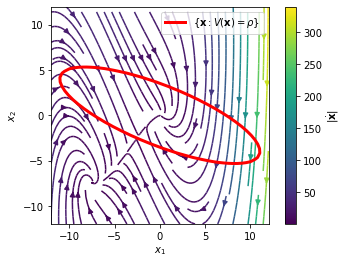

In [193]:
Pl = Q[0:2, 0:2]

xlim = (-12, 12)

def plot_V(rho):
    

    # grid of the state space
    x1 = np.linspace(*xlim)
    x2 = np.linspace(*xlim)
    X1, X2 = np.meshgrid(x1, x2)
    
    # function that evaluates V(x) at a given x
    # (looks bad, but it must accept meshgrids)
    eval_V = lambda x: sum(sum(x[i]*x[j]*Pij for j, Pij in enumerate(Pi)) for i, Pi in enumerate(Pl))
    
    # contour plot with only the rho level set
    cs = plt.contour(X1, X2, eval_V([X1, X2]), levels=[rho], colors='r', linewidths=3, zorder=3)
    
    # misc plot settings
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.gca().set_aspect('equal')
    
    # fake plot for legend
    plt.plot(0, 0, color='r', linewidth=3, label=r'$\{ \mathbf{x} : V(\mathbf{x}) = \rho \}$')
    plt.legend()
    
    return cs

f = lambda x: [-x[0] + x[1], 0.1*x[0] - 2*x[1] - x[0]**2 - 0.1*x[0]**3]

v = plot_V(1)
plot_2d_phase_portrait(f, x1lim=xlim, x2lim=xlim)

## Imposing Dynamics Constrains Explicitly for Van Der Pol

In [8]:
#THIS CODE WORKS
from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

P = np.array([[1.5, -0.5], [-0.5, 1]])

def findLambda(x, V, Vdot, count):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    #V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression()
    
    lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0].ToExpression()
    
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V))
    prog.AddSosConstraint(lambda_)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
        
    print('Status of first solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(lambda_)


def findV(x, lambda_, f, count):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    lambda_ = Polynomial(lambda_).RemoveTermsWithSmallCoefficients(1e-2).ToExpression()
        
    temp, Q = prog.NewSosPolynomial(Variables(x), 4)
    V = temp.ToExpression()
            
    prog.AddLinearConstraint(V.Substitute({x[0]: 0, x[1]:0}) == 0)
    
    Vdot = V.Jacobian(x).dot(f)
    
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V))
    
#     prog.AddSosConstraint(np.trace(Q))
    
    A = Q[0, 0]
    B = 2*Q[1, 0]
    C = Q[1, 1]
    
    prog.AddCost(A)
    prog.AddCost(C)
    prog.AddCost(-B)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
        
    k = result.get_solver_details().solution_status
                
    print('Status of second solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(V), result.GetSolution(Q)

def setup_solver():
    x_val = -100

    eps_converge = 0.01
    
    ra = 10
    
    count = 0
    
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    
    f0 = -x[1]
    f1 = x[0] + (x[0]**2 - 1) * x[1]
    
    f = np.array([f0, f1])
    
    V = x.T@P@x
    
    display(Markdown("$V(x) = " + ToLatex(
    Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
    Vdot = V.Jacobian(x).dot(f)
    
    for i in range(30): 
        lambda_ = findLambda(x, V, Vdot, count)
        
#         display(Markdown("$\lambda (x) = " + ToLatex(
#         Polynomial(lambda_).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        V, Q = findV(x, lambda_, f, count)
        
        display(Markdown("$V(x) = " + ToLatex(
        Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        Vdot = V.Jacobian(x).dot(f)
        
        count += 1
    return V, Q
    
    
V, Q = setup_solver()

$V(x) = ( - x_{0} x_{1} + 1.500000x_{0}^{2} + x_{1}^{2})$

Status of first solver on step 0: 1
Status of second solver on step 0: 1


$V(x) = ( - 2.212597x_{0} x_{1} + 0.210509x_{0} x_{1}^{3} + 0.526515x_{0}^{2} x_{1}^{2} + 0.421288x_{0}^{3} x_{1} + 3.072207x_{0}^{2} + 1.234949x_{0}^{4} + 2.309043x_{1}^{2} + 0.105246x_{1}^{4})$

Status of first solver on step 1: 1
Status of second solver on step 1: 1


$V(x) = ( - 2.188295x_{0} x_{1} + 0.817398x_{0} x_{1}^{3} + 1.336377x_{0}^{2} x_{1}^{2} + 0.927680x_{0}^{3} x_{1} + 3.342046x_{0}^{2} + 1.698995x_{0}^{4} + 2.501899x_{1}^{2} + 0.408696x_{1}^{4})$

Status of first solver on step 2: 1
Status of second solver on step 2: 1


$V(x) = ( - 2.433738x_{0} x_{1} + 1.030693x_{0} x_{1}^{3} + 1.543861x_{0}^{2} x_{1}^{2} + 1.028515x_{0}^{3} x_{1} + 3.706123x_{0}^{2} + 1.853331x_{0}^{4} + 2.790421x_{1}^{2} + 0.515342x_{1}^{4})$

Status of first solver on step 3: 1
Status of second solver on step 3: 1


$V(x) = ( - 2.558919x_{0} x_{1} + 1.125323x_{0} x_{1}^{3} + 1.649432x_{0}^{2} x_{1}^{2} + 1.086769x_{0}^{3} x_{1} + 3.876993x_{0}^{2} + 1.930568x_{0}^{4} + 2.917454x_{1}^{2} + 0.562656x_{1}^{4})$

Status of first solver on step 4: 1
Status of second solver on step 4: 1


$V(x) = ( - 2.612558x_{0} x_{1} + 1.161935x_{0} x_{1}^{3} + 1.692105x_{0}^{2} x_{1}^{2} + 1.111137x_{0}^{3} x_{1} + 3.945541x_{0}^{2} + 1.961433x_{0}^{4} + 2.964526x_{1}^{2} + 0.580961x_{1}^{4})$

Status of first solver on step 5: 1
Status of second solver on step 5: 1


$V(x) = ( - 2.633020x_{0} x_{1} + 1.175533x_{0} x_{1}^{3} + 1.708069x_{0}^{2} x_{1}^{2} + 1.120302x_{0}^{3} x_{1} + 3.971204x_{0}^{2} + 1.973197x_{0}^{4} + 2.981911x_{1}^{2} + 0.587760x_{1}^{4})$

Status of first solver on step 6: 1
Status of second solver on step 6: 1


$V(x) = ( - 2.640522x_{0} x_{1} + 1.180447x_{0} x_{1}^{3} + 1.713872x_{0}^{2} x_{1}^{2} + 1.123647x_{0}^{3} x_{1} + 3.980520x_{0}^{2} + 1.977478x_{0}^{4} + 2.988178x_{1}^{2} + 0.590217x_{1}^{4})$

Status of first solver on step 7: 1
Status of second solver on step 7: 1


$V(x) = ( - 2.643227x_{0} x_{1} + 1.182205x_{0} x_{1}^{3} + 1.715954x_{0}^{2} x_{1}^{2} + 1.124850x_{0}^{3} x_{1} + 3.983862x_{0}^{2} + 1.979012x_{0}^{4} + 2.990415x_{1}^{2} + 0.591095x_{1}^{4})$

Status of first solver on step 8: 1
Status of second solver on step 8: 1


$V(x) = ( - 2.644195x_{0} x_{1} + 1.182831x_{0} x_{1}^{3} + 1.716697x_{0}^{2} x_{1}^{2} + 1.125280x_{0}^{3} x_{1} + 3.985055x_{0}^{2} + 1.979559x_{0}^{4} + 2.991211x_{1}^{2} + 0.591409x_{1}^{4})$

Status of first solver on step 9: 1
Status of second solver on step 9: 1


$V(x) = ( - 2.644540x_{0} x_{1} + 1.183054x_{0} x_{1}^{3} + 1.716962x_{0}^{2} x_{1}^{2} + 1.125434x_{0}^{3} x_{1} + 3.985480x_{0}^{2} + 1.979754x_{0}^{4} + 2.991494x_{1}^{2} + 0.591520x_{1}^{4})$

Status of first solver on step 10: 1
Status of second solver on step 10: 1


$V(x) = ( - 2.644663x_{0} x_{1} + 1.183133x_{0} x_{1}^{3} + 1.717056x_{0}^{2} x_{1}^{2} + 1.125488x_{0}^{3} x_{1} + 3.985632x_{0}^{2} + 1.979823x_{0}^{4} + 2.991595x_{1}^{2} + 0.591560x_{1}^{4})$

Status of first solver on step 11: 1
Status of second solver on step 11: 1


$V(x) = ( - 2.644707x_{0} x_{1} + 1.183162x_{0} x_{1}^{3} + 1.717090x_{0}^{2} x_{1}^{2} + 1.125508x_{0}^{3} x_{1} + 3.985686x_{0}^{2} + 1.979847x_{0}^{4} + 2.991631x_{1}^{2} + 0.591574x_{1}^{4})$

Status of first solver on step 12: 1
Status of second solver on step 12: 1


$V(x) = ( - 2.644723x_{0} x_{1} + 1.183172x_{0} x_{1}^{3} + 1.717102x_{0}^{2} x_{1}^{2} + 1.125515x_{0}^{3} x_{1} + 3.985705x_{0}^{2} + 1.979856x_{0}^{4} + 2.991643x_{1}^{2} + 0.591579x_{1}^{4})$

Status of first solver on step 13: 1
Status of second solver on step 13: 1


$V(x) = ( - 2.644728x_{0} x_{1} + 1.183175x_{0} x_{1}^{3} + 1.717106x_{0}^{2} x_{1}^{2} + 1.125517x_{0}^{3} x_{1} + 3.985712x_{0}^{2} + 1.979859x_{0}^{4} + 2.991648x_{1}^{2} + 0.591581x_{1}^{4})$

Status of first solver on step 14: 1
Status of second solver on step 14: 1


$V(x) = ( - 2.644730x_{0} x_{1} + 1.183176x_{0} x_{1}^{3} + 1.717107x_{0}^{2} x_{1}^{2} + 1.125518x_{0}^{3} x_{1} + 3.985714x_{0}^{2} + 1.979860x_{0}^{4} + 2.991649x_{1}^{2} + 0.591581x_{1}^{4})$

Status of first solver on step 15: 1
Status of second solver on step 15: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125518x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 16: 1
Status of second solver on step 16: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125518x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 17: 1
Status of second solver on step 17: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 18: 1
Status of second solver on step 18: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 19: 1
Status of second solver on step 19: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 20: 1
Status of second solver on step 20: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 21: 1
Status of second solver on step 21: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 22: 1
Status of second solver on step 22: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 23: 1
Status of second solver on step 23: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 24: 1
Status of second solver on step 24: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 25: 1
Status of second solver on step 25: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 26: 1
Status of second solver on step 26: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 27: 1
Status of second solver on step 27: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 28: 1
Status of second solver on step 28: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

Status of first solver on step 29: 1
Status of second solver on step 29: 1


$V(x) = ( - 2.644731x_{0} x_{1} + 1.183177x_{0} x_{1}^{3} + 1.717108x_{0}^{2} x_{1}^{2} + 1.125519x_{0}^{3} x_{1} + 3.985715x_{0}^{2} + 1.979861x_{0}^{4} + 2.991650x_{1}^{2} + 0.591582x_{1}^{4})$

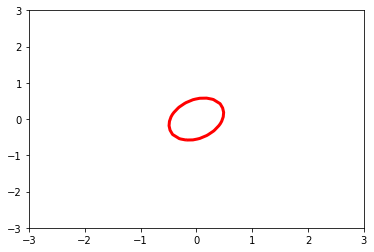

In [26]:
x0 = list(V.GetVariables())[0]
x1 = list(V.GetVariables())[1]

xlim = (-3, 3)

def plot_V(V, col, lab, xlim): 
    x0 = np.linspace(*xlim)
    x1 = np.linspace(*xlim)
    X0, X1 = np.meshgrid(x0, x1)
    
    Z = np.zeros_like(X0)
    
    def f(x, y, V): 
        x0 = list(V.GetVariables())[0]
        x1 = list(V.GetVariables())[1]
        
        return V.Evaluate({x0: x, x1: y})
    
    for i in range(len(X0)):
        for j in range(len(X0[i])):
            Z[i, j] = f(X0[i, j], X1[i, j], V)
    
    cs = plt.contour(X0, X1, Z, levels=[1], colors=col, linewidths=3, zorder=3)
    
    return cs
plot_V(V, 'r', 'lol', xlim)

In [14]:
list(V.GetVariables())[0]

Variable('x(0)', Continuous)

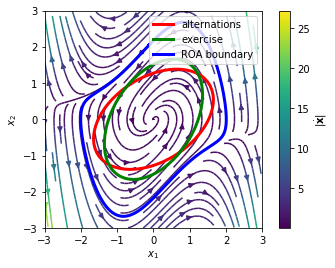

In [195]:
from pydrake.examples.van_der_pol import VanDerPolOscillator

Pl = Q[0:2, 0:2]

xlim = (-3, 3)

def plot_V(rho, Pl, col, lab):
    
    # grid of the state space
    x1 = np.linspace(*xlim)
    x2 = np.linspace(*xlim)
    X1, X2 = np.meshgrid(x1, x2)
    
    # function that evaluates V(x) at a given x
    # (looks bad, but it must accept meshgrids)
    eval_V = lambda x: sum(sum(x[i]*x[j]*Pij for j, Pij in enumerate(Pi)) for i, Pi in enumerate(Pl))
    
    # contour plot with only the rho level set
    cs = plt.contour(X1, X2, eval_V([X1, X2]), levels=[rho], colors=col, linewidths=3, zorder=3)
    
    # misc plot settings
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.gca().set_aspect('equal')
    
    # fake plot for legend
    plt.plot(0, 0, color=col, linewidth=3, label=lab)
    plt.legend()
    
    return cs

limit_cycle = VanDerPolOscillator.CalcLimitCycle()
f = lambda x: [- x[1], x[0] + (x[0]**2 - 1) * x[1]]

plot_V(1, Pl, 'r', 'alternations')
plot_V(2.3, P, 'g', 'exercise')
plot_2d_phase_portrait(f, x1lim=xlim, x2lim=xlim)
plt.plot(limit_cycle[0], limit_cycle[1], color='b', linewidth=3, label='ROA boundary')
plt.legend(loc=1)

## Imposing Dynamics Constraints Implicitly

In [223]:
#THIS CODE WORKS

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')

def find_implicit_lambdas(x, xd, V, Vdot, g):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
        
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
  
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]))
    
    return result.GetSolution(lambda_), np.array(lambda_g_results)

def find_implicit_V(x, xd, lambda_, lambda_g, g, V_degree):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    
    y = np.hstack([x, xd])
    
    V, Q = prog.NewSosPolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
    
    #prog.AddLinearCost(np.trace(Q))    
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0}) == 0)
    
    A = Q[0, 0]
    B = 2*Q[1, 0]
    C = Q[1, 1]
    
    prog.AddCost(A)
#     prog.AddCost(C)
#     prog.AddCost(-B)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("V solution status: " + str(k))
    
    assert result.is_success()
        
    return result.GetSolution(V), result.GetSolution(Q)


def problem_solver_implicit():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    xd = prog.NewIndeterminates(2, "xd")
        
    g0 = -xd[0] -x[0] + x[1]
    g1 = -xd[1] + 0.1*x[0] - 2*x[1] - x[0]**2 - 0.1*x[0]**3
    
    g = np.array([g0, g1])
    
    V_degree = 4
    V = x[0]**2 + x[1]**2
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    for i in range(8):
        lambda_, lambda_g = find_implicit_lambdas(x, xd, V, Vdot, g_poly)
#         display(Markdown("$ \lambda(x)="+ToLatex(lambda_.ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[0].ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[1].ToExpression())+"$"))
        
        V, Q = find_implicit_V(x, xd, lambda_, lambda_g, g_poly, V_degree)
        
        V = V.RemoveTermsWithSmallCoefficients(1e-5)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))

problem_solver_implicit()

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000024559x_{0} - 0.030868905x_{0} x_{1} + 0.058721122x_{0} x_{1}^{2} + 0.139484925x_{0}^{2} x_{1} + 0.475859360x_{0}^{2} x_{1}^{2} + 0.000619251x_{0}^{3} x_{1} + 0.851971969x_{0}^{2} + 0.058578325x_{0}^{3} + 0.316085022x_{0}^{4} + 0.974423821x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000012239x_{0} - 0.076667543x_{0} x_{1} + 0.056642844x_{0} x_{1}^{2} + 0.169061747x_{0}^{2} x_{1} + 0.652799171x_{0}^{2} x_{1}^{2} - 0.057745797x_{0}^{3} x_{1} + 0.725705298x_{0}^{2} + 0.049723454x_{0}^{3} + 0.446926334x_{0}^{4} + 1.047071728x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=( - 0.105958041x_{0} x_{1} + 0.057859629x_{0} x_{1}^{2} + 0.199919972x_{0}^{2} x_{1} + 0.754468226x_{0}^{2} x_{1}^{2} - 0.106922996x_{0}^{3} x_{1} + 0.668432781x_{0}^{2} + 0.044513357x_{0}^{3} + 0.511953804x_{0}^{4} + 1.117070750x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=( - 0.127285316x_{0} x_{1} + 0.060452964x_{0} x_{1}^{2} + 0.228911740x_{0}^{2} x_{1} + 0.823917302x_{0}^{2} x_{1}^{2} - 0.134765255x_{0}^{3} x_{1} + 0.648084424x_{0}^{2} + 0.042228974x_{0}^{3} + 0.574847211x_{0}^{4} + 1.184849129x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=( - 0.144437951x_{0} x_{1} + 0.060838015x_{0} x_{1}^{2} + 0.252845384x_{0}^{2} x_{1} + 0.878435269x_{0}^{2} x_{1}^{2} - 0.163421921x_{0}^{3} x_{1} + 0.652247126x_{0}^{2} + 0.039983134x_{0}^{3} + 0.610702080x_{0}^{4} + 1.247271423x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=( - 0.157579901x_{0} x_{1} + 0.063057672x_{0} x_{1}^{2} + 0.275653044x_{0}^{2} x_{1} + 0.919667965x_{0}^{2} x_{1}^{2} - 0.177897425x_{0}^{3} x_{1} + 0.667294233x_{0}^{2} + 0.038484897x_{0}^{3} + 0.653199707x_{0}^{4} + 1.309572596x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=( - 0.169622159x_{0} x_{1} + 0.063337602x_{0} x_{1}^{2} + 0.294662473x_{0}^{2} x_{1} + 0.947662337x_{0}^{2} x_{1}^{2} - 0.198414600x_{0}^{3} x_{1} + 0.687670199x_{0}^{2} + 0.036555199x_{0}^{3} + 0.669939862x_{0}^{4} + 1.364575848x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=( - 0.190533621x_{0} x_{1} + 0.076027177x_{0} x_{1}^{2} + 0.385075883x_{0}^{2} x_{1} + 1.532167074x_{0}^{2} x_{1}^{2} - 0.200661367x_{0}^{3} x_{1} + 0.761247563x_{0}^{2} + 0.079839043x_{0}^{3} + 1.149314609x_{0}^{4} + 1.602610979x_{1}^{2})$

In [214]:
#doing the van der pol oscillator implicitly

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')

def find_implicit_lambdas(x, xd, V, Vdot, g):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
        
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
  
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(1e-5))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(1e-5), np.array(lambda_g_results)

def find_implicit_V(x, xd, lambda_, lambda_g, g, V_degree):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    
    y = np.hstack([x, xd])
        
    V, Q = prog.NewSosPolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
    
    prog.AddLinearCost(np.trace(Q))    
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0}) == 0)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("V solution status: " + str(k))
    
    assert result.is_success()
        
    return result.GetSolution(V), result.GetSolution(Q)


def problem_solver_implicit():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    xd = prog.NewIndeterminates(2, "xd")
        
    g0 = xd[0] + x[1]
    g1 = xd[1] - x[0] - (x[0]**2 - 1)*x[1]
    
    g = np.array([g0, g1])
    
    V_degree = 2
    V = 1.5*x[0]**2 + x[1]**2 - x[0]*x[1]
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    for i in range(20):
        lambda_, lambda_g = find_implicit_lambdas(x, xd, V, Vdot, g_poly)
        
#         display(Markdown("$ \lambda(x)="+ToLatex(lambda_.ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[0].ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[1].ToExpression())+"$"))
#         print(alpha)
        
        V, Q = find_implicit_V(x, xd, lambda_, lambda_g, g_poly, V_degree)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V, Q = problem_solver_implicit()

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} - 0.866401137x_{0} x_{1} + 1.181378018x_{0}^{2} + 0.824172006x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} - 0.760136138x_{0} x_{1} + 0.979033618x_{0}^{2} + 0.684480623x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} - 0.671611267x_{0} x_{1} + 0.871329359x_{0}^{2} + 0.603891690x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} - 0.606189482x_{0} x_{1} + 0.804320068x_{0}^{2} + 0.551695766x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} - 0.557504198x_{0} x_{1} + 0.757575284x_{0}^{2} + 0.514675907x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} - 0.520978138x_{0} x_{1} + 0.723077444x_{0}^{2} + 0.487505854x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} - 0.493823783x_{0} x_{1} + 0.697149597x_{0}^{2} + 0.467584695x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} - 0.474157936x_{0} x_{1} + 0.677832754x_{0}^{2} + 0.453340390x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} - 0.460425699x_{0} x_{1} + 0.663825544x_{0}^{2} + 0.443503084x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} - 0.451169811x_{0} x_{1} + 0.654036226x_{0}^{2} + 0.436987292x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} - 0.446539438x_{0} x_{1} + 0.646715206x_{0}^{2} + 0.434202733x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} - 0.442336796x_{0} x_{1} + 0.643964307x_{0}^{2} + 0.431521832x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} - 0.440185673x_{0} x_{1} + 0.640794454x_{0}^{2} + 0.430298064x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} - 0.438113296x_{0} x_{1} + 0.639586444x_{0}^{2} + 0.429010390x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} - 0.437201864x_{0} x_{1} + 0.638040695x_{0}^{2} + 0.428505250x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} - 0.436187695x_{0} x_{1} + 0.637541585x_{0}^{2} + 0.427877969x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} - 0.435741852x_{0} x_{1} + 0.636788720x_{0}^{2} + 0.427659081x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} - 0.435221598x_{0} x_{1} + 0.636547617x_{0}^{2} + 0.427337954x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} - 0.435016948x_{0} x_{1} + 0.636164416x_{0}^{2} + 0.427237456x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} - 0.434750755x_{0} x_{1} + 0.636054804x_{0}^{2} + 0.427071453x_{1}^{2})$

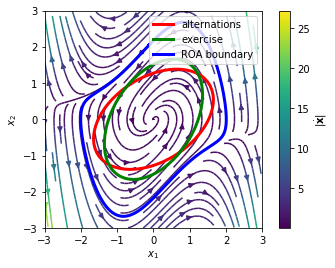

In [215]:
from pydrake.examples.van_der_pol import VanDerPolOscillator

Pl = Q[0:2, 0:2]

xlim = (-3, 3)

def plot_V(rho, Pl, col, lab):
    
    # grid of the state space
    x1 = np.linspace(*xlim)
    x2 = np.linspace(*xlim)
    X1, X2 = np.meshgrid(x1, x2)
    
    # function that evaluates V(x) at a given x
    # (looks bad, but it must accept meshgrids)
    eval_V = lambda x: sum(sum(x[i]*x[j]*Pij for j, Pij in enumerate(Pi)) for i, Pi in enumerate(Pl))
    
    # contour plot with only the rho level set
    cs = plt.contour(X1, X2, eval_V([X1, X2]), levels=[rho], colors=col, linewidths=3, zorder=3)
    
    # misc plot settings
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.gca().set_aspect('equal')
    
    # fake plot for legend
    plt.plot(0, 0, color=col, linewidth=3, label=lab)
    plt.legend()
    
    return cs

limit_cycle = VanDerPolOscillator.CalcLimitCycle()
f = lambda x: [- x[1], x[0] + (x[0]**2 - 1) * x[1]]

plot_V(1, Pl, 'r', 'alternations')
plot_V(2.3, P, 'g', 'exercise')
plot_2d_phase_portrait(f, x1lim=xlim, x2lim=xlim)
plt.plot(limit_cycle[0], limit_cycle[1], color='b', linewidth=3, label='ROA boundary')
plt.legend(loc=1)